In [2]:
pip install pandas openpyxl

In [85]:
pip install holidays


     ---------------------------------------- 1.0/1.0 MB 4.4 MB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.


In [64]:
pip install pmdarima


     ------------------------------------ 615.0/615.0 kB 716.5 kB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.


In [1]:
import pandas as pd
from statsmodels.tsa.statespace.sarimax import SARIMAX
import matplotlib.pyplot as plt
import holidays

In [2]:
# Load the Excel file (replace with your actual file path)
file_path = "mrtssales92-present.xlsx"
all_sheets = pd.read_excel(file_path, sheet_name=None, header=None)

processed_sheets = {}

for sheet_name, df in all_sheets.items():
    # Step 1: Remove first 4 rows and first column
    df = df.iloc[4:, 1:]

    # Step 2: Keep only rows up to 70 (0-indexed, so index 0–65 = 66 rows max)
    df = df.iloc[:66, :]

    # Step 3: Transpose
    df_transposed = df.transpose()

    # Step 4: Reset column names
    new_header = df_transposed.iloc[0]         # Take first row as header (business types)
    df_transposed = df_transposed[1:]          # Remove that row from data
    df_transposed.columns = new_header         # Set new headers

    # Step 5: Set index as month/year (e.g., "Jan 2025")
    df_transposed.reset_index(drop=True, inplace=True)
    
    processed_sheets[sheet_name] = df_transposed

# Save to a new Excel file
with pd.ExcelWriter("transformed_output.xlsx", engine='openpyxl') as writer:
    for name, sheet in processed_sheets.items():
        sheet.to_excel(writer, sheet_name=name, index=False)

print("All sheets cleaned, transposed, and saved to 'transformed_output.xlsx'")


All sheets cleaned, transposed, and saved to 'transformed_output.xlsx'


In [3]:
# Load the transformed Excel file
file_path = "transformed_output.xlsx"
all_sheets = pd.read_excel(file_path, sheet_name=None)

modified_sheets = {}

for sheet_name, df in all_sheets.items():
    # Step 1: Rename first column to 'Month'
    df.rename(columns={df.columns[0]: 'Month'}, inplace=True)
    
    # Step 2: Drop the second column
    df.drop(df.columns[1], axis=1, inplace=True)

    # Save cleaned sheet
    modified_sheets[sheet_name] = df

# Save to a new Excel file
with pd.ExcelWriter("final_output.xlsx", engine='openpyxl') as writer:
    for name, sheet in modified_sheets.items():
        sheet.to_excel(writer, sheet_name=name, index=False)

print("Final cleanup done: 2nd column removed, 1st column renamed to 'Month'. Saved as 'final_output.xlsx'")


Final cleanup done: 2nd column removed, 1st column renamed to 'Month'. Saved as 'final_output.xlsx'


In [4]:
# File with transformed sheets
file_path = "final_output.xlsx"

# List of desired columns to keep
columns_to_keep = [
    "Month",
    "Restaurants and other eating places"
]

# Load all sheets
all_sheets = pd.read_excel(file_path, sheet_name=None)

filtered_sheets = {}

for sheet_name, df in all_sheets.items():
    # Ensure 'Month' column is present and correctly labeled
    df.rename(columns={df.columns[0]: 'Month'}, inplace=True)

    # Keep only specified columns that exist in the current sheet
    available_cols = [col for col in columns_to_keep if col in df.columns]
    df_filtered = df[available_cols]

    filtered_sheets[sheet_name] = df_filtered

# Save to new file
with pd.ExcelWriter("filtered_columns_output.xlsx", engine="openpyxl") as writer:
    for name, sheet in filtered_sheets.items():
        sheet.to_excel(writer, sheet_name=name, index=False)

print("Extracted specified columns from all sheets into 'filtered_columns_output.xlsx'")


Extracted specified columns from all sheets into 'filtered_columns_output.xlsx'


In [5]:
#Remove total/py/cum

file_path = "filtered_columns_output.xlsx"

# List of desired columns to keep
columns_to_keep = ["Month", "Restaurants and other eating places"]

# Load all sheets
all_sheets = pd.read_excel(file_path, sheet_name=None)

filtered_sheets = {}

for sheet_name, df in all_sheets.items():
    # Rename first column to 'Month'
    df.rename(columns={df.columns[0]: 'Month'}, inplace=True)

    # Keep only required columns that are available
    available_cols = [col for col in columns_to_keep if col in df.columns]
    df_filtered = df[available_cols].copy()

    # Drop rows like 'TOTAL', 'CY CUM', 'PY CUM' (non-date values)
    df_filtered['Month_clean'] = df_filtered['Month'].astype(str)
    df_filtered = df_filtered[~df_filtered['Month_clean'].str.contains(r'TOTAL|CUM', case=False)]
    
    # Remove the helper column
    df_filtered.drop(columns='Month_clean', inplace=True)

    # Save cleaned sheet
    filtered_sheets[sheet_name] = df_filtered

# Save to new file
with pd.ExcelWriter("filtered_columns_cleaned.xlsx", engine="openpyxl") as writer:
    for name, sheet in filtered_sheets.items():
        sheet.to_excel(writer, sheet_name=name, index=False)

print("✅ Cleaned sheets saved to 'filtered_columns_cleaned.xlsx'")


✅ Cleaned sheets saved to 'filtered_columns_cleaned.xlsx'


In [6]:
df= pd.read_excel('filtered_columns_cleaned.xlsx', sheet_name=None, header=None)


In [7]:
df['2025']


,0,1
0,Month,Restaurants and other eating places
1,Jan. 2025,79835
2,Feb. 2025,78245
3,Mar. 2025,92223
4,Apr. 2025(p),88379


In [8]:
file_path = "filtered_columns_cleaned.xlsx"
all_sheets = pd.read_excel(file_path, sheet_name=None)

frames = []

for sheet_name, df in all_sheets.items():
    df.rename(columns={df.columns[0]: 'Month'}, inplace=True)

    # Remove unwanted rows like TOTAL, CUMULATIVE
    df = df[~df['Month'].astype(str).str.contains(r'TOTAL|CUM', case=False, na=False)]

    # Clean 'Month'
    df['Month'] = df['Month'].astype(str)
    df['Month'] = df['Month'].str.replace(r"\s*\(.\)", "", regex=True)
    df['Month'] = df['Month'].str.replace(r"[^\w\s.]", "", regex=True)
    df['Month'] = df['Month'].str.strip()

    # Only keep valid rows
    if 'Restaurants and other eating places' in df.columns:
        df = df[['Month', 'Restaurants and other eating places']]
        df['Month'] = pd.to_datetime(df['Month'], errors='coerce')
        df.dropna(subset=['Month'], inplace=True)

        df.set_index('Month', inplace=True)
        df.sort_index(inplace=True)
        frames.append(df)

# Combine all cleaned sheets
full_df = pd.concat(frames)

# Ensure sorting after concatenation
full_df.sort_index(inplace=True)

# Now extract the series
series = full_df['Restaurants and other eating places']

# Confirm sorted tail
print("Final date range:", series.index.min(), "→", series.index.max())
print(series.tail(10))



Final date range: 1992-01-01 00:00:00 → 2025-04-01 00:00:00
Month
2024-07-01    86750
2024-08-01    88263
2024-09-01    81563
2024-10-01    84944
2024-11-01    82774
2024-12-01    86161
2025-01-01    79835
2025-02-01    78245
2025-03-01    92223
2025-04-01    88379
Name: Restaurants and other eating places, dtype: int64


In [9]:
# ✅ Assign final merged dataframe to df
df = full_df.copy()

# ✅ Step 2: Define U.S. holidays for years 1994–2025
import holidays
us_holidays = holidays.UnitedStates(years=range(1994, 2026))

# ✅ Step 3: Define function to check if any holiday is in that month
def is_holiday_month(date):
    all_days = pd.date_range(start=date, periods=31, freq='D')
    all_days = all_days[all_days.month == date.month]  # Keep days within the same month
    return int(any(day in us_holidays for day in all_days))

# ✅ Step 4: Apply the function to index (which is Month)
df['Holiday_Flag'] = df.index.to_series().apply(is_holiday_month)

# ✅ Preview tail
print(df.reset_index()[['Month', 'Holiday_Flag']].tail())




         Month  Holiday_Flag
395 2024-12-01             1
396 2025-01-01             1
397 2025-02-01             1
398 2025-03-01             0
399 2025-04-01             0


In [10]:
# Fix frequency safely
df = df.asfreq('MS')  # Will insert NaNs for missing months


In [11]:
# Rename column first
df.rename(columns={'Restaurants and other eating places': 'Revenue'}, inplace=True)

# Set index if needed
if 'Month' in df.columns:
    df.set_index('Month', inplace=True)

# ❗ Remove rows with NaNs (do this before defining variables)
df = df[df['Revenue'].notna() & df['Holiday_Flag'].notna()]

# ✅ Define target and exogenous features AFTER cleaning
series = df['Revenue']
exog = df[['Holiday_Flag']]





In [12]:
#Different combination trying for seasonal trend(p,d,q,how many month for trend going back) and normal (p,d,q) for how many old days 

from pmdarima import auto_arima

model = auto_arima(
    series,
    seasonal=True,     # For SARIMA
    m=12,              # 12 = Monthly seasonality
    trace=True,
    error_action='ignore',
    suppress_warnings=True,
    stepwise=True
)

print(model.summary())
print("Best Order (p,d,q):", model.order)
print("Best Seasonal Order (P,D,Q,s):", model.seasonal_order)


Performing stepwise search to minimize aic
 ARIMA(2,1,2)(1,0,1)[12] intercept   : AIC=inf, Time=3.09 sec
 ARIMA(0,1,0)(0,0,0)[12] intercept   : AIC=7493.896, Time=0.06 sec
 ARIMA(1,1,0)(1,0,0)[12] intercept   : AIC=7340.070, Time=0.73 sec
 ARIMA(0,1,1)(0,0,1)[12] intercept   : AIC=7394.357, Time=0.51 sec
 ARIMA(0,1,0)(0,0,0)[12]             : AIC=7493.600, Time=0.04 sec
 ARIMA(1,1,0)(0,0,0)[12] intercept   : AIC=7451.200, Time=0.10 sec
 ARIMA(1,1,0)(2,0,0)[12] intercept   : AIC=7290.146, Time=2.53 sec
 ARIMA(1,1,0)(2,0,1)[12] intercept   : AIC=7246.844, Time=6.70 sec
 ARIMA(1,1,0)(1,0,1)[12] intercept   : AIC=7233.199, Time=2.10 sec
 ARIMA(1,1,0)(0,0,1)[12] intercept   : AIC=7396.557, Time=0.27 sec
 ARIMA(1,1,0)(1,0,2)[12] intercept   : AIC=7247.028, Time=5.39 sec
 ARIMA(1,1,0)(0,0,2)[12] intercept   : AIC=7357.087, Time=2.36 sec
 ARIMA(1,1,0)(2,0,2)[12] intercept   : AIC=7317.044, Time=8.30 sec
 ARIMA(0,1,0)(1,0,1)[12] intercept   : AIC=7230.033, Time=2.02 sec
 ARIMA(0,1,0)(0,0,1)[12]

In [13]:
series

Month
1992-01-01    13130
1992-02-01    13276
1992-03-01    14135
1992-04-01    13858
1992-05-01    14854
              ...  
2024-12-01    86161
2025-01-01    79835
2025-02-01    78245
2025-03-01    92223
2025-04-01    88379
Freq: MS, Name: Revenue, Length: 400, dtype: int64

In [14]:
# ✅ Fit SARIMAX
from statsmodels.tsa.statespace.sarimax import SARIMAX

model = SARIMAX(
    series,
    exog=exog,
    order=(3, 1, 2),
    seasonal_order=(2, 0, 1, 12),
    enforce_stationarity=False,
    enforce_invertibility=False
)

results = model.fit()

print(results.summary())

C:\Users\khush\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


                                      SARIMAX Results                                       
Dep. Variable:                              Revenue   No. Observations:                  400
Model:             SARIMAX(3, 1, 2)x(2, 0, [1], 12)   Log Likelihood               -3340.266
Date:                              Fri, 27 Jun 2025   AIC                           6700.533
Time:                                      10:40:25   BIC                           6739.722
Sample:                                  01-01-1992   HQIC                          6716.096
                                       - 04-01-2025                                         
Covariance Type:                                opg                                         
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
Holiday_Flag  -629.2347    291.786     -2.156      0.031   -1201.126     -57.344
ar.L1        

In [15]:
# Step 1: Create next 12 months date range
future_months = pd.date_range(
    start=series.index[-1] + pd.offsets.MonthBegin(1), 
    periods=12, 
    freq='MS'
)

# Step 2: Create future exogenous (holiday flag) values
future_exog = pd.DataFrame({
    'Holiday_Flag': future_months.to_series().apply(is_holiday_month).values
}, index=future_months)

# Step 3: Forecast
forecast = results.forecast(steps=12, exog=future_exog)


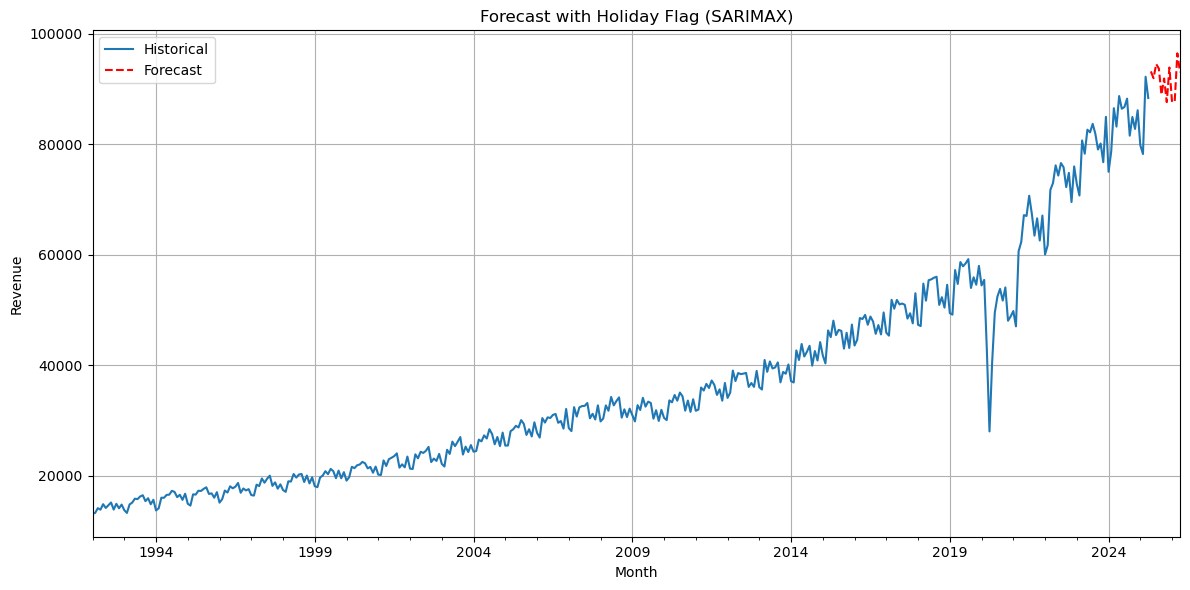

In [16]:


plt.figure(figsize=(12, 6))
series.plot(label='Historical')
forecast.plot(label='Forecast', color='red', linestyle='--')
plt.title('Forecast with Holiday Flag (SARIMAX)')
plt.xlabel('Month')
plt.ylabel('Revenue')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [17]:
print(series.index.min(), "→", series.index.max())


1992-01-01 00:00:00 → 2025-04-01 00:00:00


In [18]:
# Choose how many months you want to reserve for testing
test_size = 12

# Train-test split
train = series[:-test_size]
test = series[-test_size:]
train_exog = exog[:-test_size]
test_exog = exog[-test_size:]


In [19]:
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np

mae = mean_absolute_error(test, forecast)
rmse = np.sqrt(mean_squared_error(test, forecast))
mape = np.mean(np.abs((test - forecast) / test)) * 100  # Mean Absolute Percentage Error

print(f"MAE: {mae:.2f}")
print(f"RMSE: {rmse:.2f}")
print(f"MAPE: {mape:.2f}%")


MAE: 6371.96
RMSE: 6580.20
MAPE: nan%


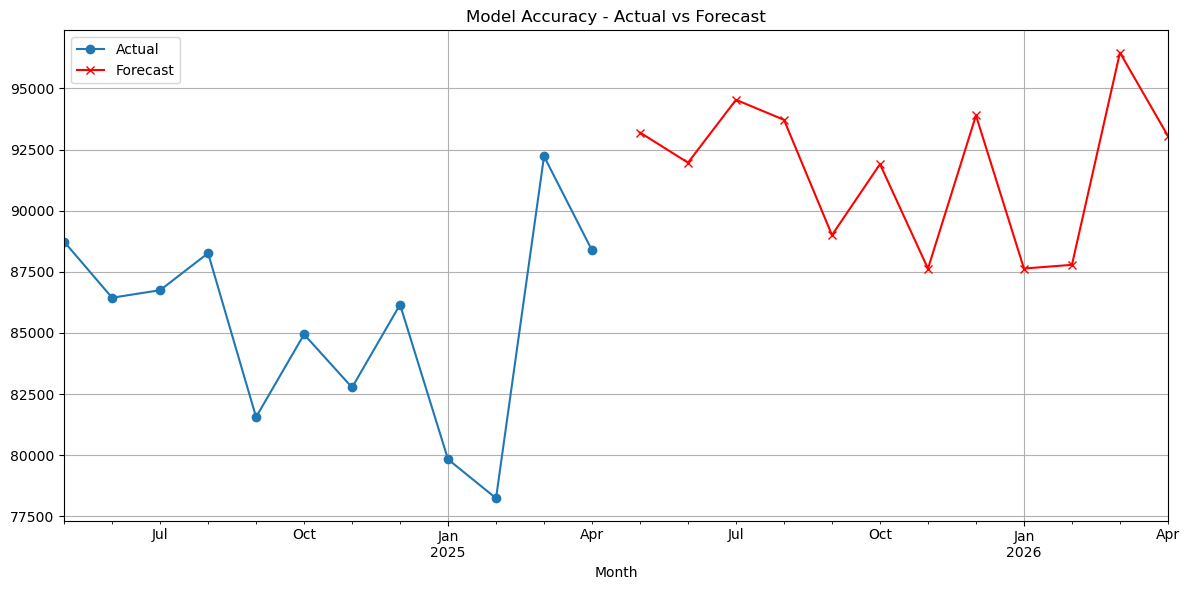

In [20]:
#Difference between forecasted and predicted value

plt.figure(figsize=(12, 6))
test.plot(label='Actual', marker='o')
forecast.plot(label='Forecast', marker='x', color='red')
plt.title('Model Accuracy - Actual vs Forecast')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [21]:
# Create a forecast DataFrame
forecast_df = pd.DataFrame({
    'Revenue': forecast.values,
    'Type': 'Forecast',
    'Holiday_Flag': future_exog['Holiday_Flag'].values
}, index=future_months)

# Optional: Set proper name for index
forecast_df.index.name = 'Month'


In [22]:
# Copy existing cleaned historical data
actual_df = df[['Revenue', 'Holiday_Flag']].copy()
actual_df['Type'] = 'Actual'


In [23]:
combined_df = pd.concat([actual_df, forecast_df])
combined_df.reset_index(inplace=True)  # For Power BI compatibility


In [24]:
combined_df.to_excel("combined_forecast_output.xlsx", index=False)
